In [1]:
%matplotlib inline
%run support.py
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')
#datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826"
datafolder = "./data/Measurements/Cooldown20200826"

# Demagnetization

In [2]:
filename = f"d637_time.h5"
removepoints = [0,1]                         # I am removing the first couple of points because the magnetic field was not read correctly there. Only 3 points
removepoints.extend(list(range(2422, 2442))) # I am removing these points because they are spikes related to changing
removepoints.extend(list(range(3024, 3044))) # the excitation on the lock-in, reproducible, and well understood.

with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    t_demag = np.delete(np.array(f['x_array']), removepoints)
    gCu = np.delete(np.array(f['gCu']), removepoints)
    b_demag = np.delete(np.array(f['bdemagIPSB']), removepoints)
    b_demag[0:2]=b_demag[2:4]
Bf = b_demag[-1]
gCu_demag = 1/(1/MakeSmoothie(gCu) - 2*R_wire)
gCu[gCu>gT_Cu] = np.nan
TCu_demag = Tcbt_Cu(gCu_demag/gT_Cu, Ec=Ec_Cu*1e-3)
t_demag = t_demag - t_demag[0]

flt1 = np.logical_and(TCu_demag>0.010, t_demag/3600 >2)
flt2 = np.logical_and(TCu_demag>0.0004, t_demag/3600 >3.2)
flt = np.logical_or(flt1, flt2)
TCu_demag[flt] = np.nan

print(np.mean(TCu_demag[0:10]))

0.00860787571959831


# 2nd Harmonic

In [3]:
filename = f"d639_c12.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    v = np.array(f['x_array']) /1000  # v is in units of volts
    gCu = np.array(f['gCu'])
    VyCu2H_2ndH = np.array(f['VyCu2H'])
gCu_2ndH = 1/(1/gCu - 2*R_wire)
vCu_2ndH = v / ( 2*gCu*R_wire + 1 )

# Warm up

In [4]:
# Low T source-drain trace
filename = f"d638_c12.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    v = np.array(f['x_array']) /1000  # v is in units of volts
    gCu = np.array(f['gCu'])
    voff = np.array(f['VoffsCu'])
    logs = json.loads(f['metadata'].attrs['sweep_logs'])
    ti_lowestT = datetime.datetime.strptime(logs['time_started'], '%d/%m/%Y %H:%M:%S').timestamp()
    tf_lowestT = datetime.datetime.strptime(logs['time_completed'], '%d/%m/%Y %H:%M:%S').timestamp()
    tm_lowestT = (ti_lowestT + tf_lowestT)/2

gCu_lowT = 1/(1/gCu - 2*R_wire)
g0Cu_lowT = np.mean(gCu_lowT[int(gCu_lowT.shape[0]/2)+1:int(gCu_lowT.shape[0]/2)+6], axis=0)
print(f"g0Cu_lowT/gT={g0Cu_lowT/gT_Cu}")
vCu_lowT = v / ( 2*gCu*R_wire + 1 )
voff_lowT = voff[0]

flt = np.logical_and(vCu_lowT*1e6 > -0.3, vCu_lowT*1e6 < 1.0)
vfit_lowT = vCu_lowT[flt]
a,b,c = np.polyfit(vfit_lowT, gCu_lowT[flt], 2)
g0Cufit_lowT = np.poly1d([a,b,c])
v0Cu_lowT = -b/(2*a)
g0Cu_lowT = (-b*b+4*a*c)/(4*a)
lowestT = Tcbt_Cu(g0Cu_lowT/gT_Cu, Ec_Cu*1e-3)
print(lowestT)

# Warm-up curve
vfit = np.linspace(-1e-6, 1e-6, 201)
warmup_filenums = [640]
warmup_t, warmup_v, warmup_g0, warmup_voffset, warmup_g2d = [tm_lowestT], [], [g0Cu_lowT], [voff_lowT], []
for i, fn in enumerate(warmup_filenums):
    filename = f"d{fn}_time_c12.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        v = np.array(f['y_array'])/1000
        gCu = np.array(f['gCu'])
        voff = np.array(f['VoffsCu'])
    gCu = 1/(1/gCu - 2*R_wire)
    #vCu = np.array([v / ( 2*gCu[:,j]*R_wire + 1 ) for j in range(len(t))]).T
    vCu = np.array([v for j in range(len(t))]).T

    # Manually repairing some data points
    if i==0:
        gCu[0:4] = gCu[4:8]

    warmup_t.extend(t)
    warmup_v.append(vCu)
    warmup_voffset.extend(np.mean(voff, axis=0))
    warmup_g2d.append(gCu)
    
    #warmup_g0.append(np.mean(gCu[int(gCu.shape[0]/2)-3:int(gCu.shape[0]/2)+3,:], axis=0))
    g0_arr = []
    for j in range(len(t)):
        flt = np.logical_and(vCu[:,j] > np.min(vfit), vCu[:,j]*1e6 < np.max(vfit))
        a,b,c = np.polyfit(vCu[flt,j]*1e6, gCu[flt,j], 2)
        if -b/(2*a) < 1 and -b/(2*a) > -1 and a > 0:
            g0 = (-b*b+4*a*c)/(4*a)
        else:
            poly = np.poly1d([a,b,c])
            gfit = poly(vfit)
            g0 = np.min(gfit)
        g0_arr.append(g0)
    warmup_g0.extend(g0_arr)

warmup_t = np.array(warmup_t)
warmup_voffset = np.array(warmup_voffset)
warmup_g0 = np.array(warmup_g0)

g0Cu_lowT/gT=0.33432883611904085
0.00022423213066946493


/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/var/opt/jupyterhub/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


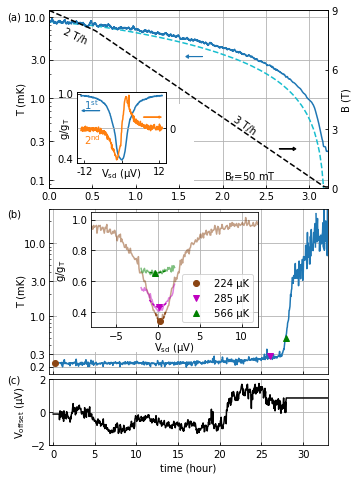

In [5]:
fig = plt.figure(figsize=(5, 8))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[6, 8], hspace=0.1, figure=fig)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], hspace=0.05, height_ratios=[5, 2])
ax=[]
ax.append(plt.subplot(gs1[0]))
ax.append(plt.subplot(gs2[0]))
ax.append(plt.subplot(gs2[1]))

# Precool
#ax[0].plot(t_precool/3600, TCu_precool*1e3, label=r"$\mathrm{T_{CBT}}$")
#ax[0].plot(tmc_precool/3600, Tmc_precool*1e3, color=colors[6], label=r"$\mathrm{T_{MC}}$")
#mag_lastindex = np.max(np.where(b_precool<9))
#ax[0].fill_between([t_precool[0]/3600, t_precool[mag_lastindex]/3600], [4,4], [30,30], color='k', alpha=0.1)
#ax[0].text(2, 5.5, "Field\nramp up")

#ax[0].set_ylabel("T (mK)")
#ax[0].grid()
#ax[0].legend()
#ax[0].set_xlim(0,40)
#ax[0].set_yticks(np.linspace(5,30,6))
#ax[0].set_ylim(4,30)

# Ideal demag
T0_ideal = np.mean(TCu_demag[0:30])
T_ideal = T0_ideal * b_demag/9
flt = b_demag > 0.050
ax[0].semilogy(t_demag[flt]/3600, T_ideal[flt]*1e3, '--', color=colors[9], label='Ideal')

# Demagnetization
ax[0].semilogy(t_demag/3600, TCu_demag*1e3)
ax[0].grid()
ax[0].yaxis.set_label_coords(-.08,.5)
ax[0].set_xlim(0,t_demag[-1]/3600)
ax[0].set_ylim(0.08,12)
ax[0].set_yticks([0.1,0.3,1,3,10])
ax[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax[0].arrow(0.55, 0.74, -0.05, 0, head_width=0.02, head_length=.01, color=colors[0], transform=ax[0].transAxes, zorder=10)
ax[0].arrow(0.825, 0.22, 0.05, 0, head_width=0.02, head_length=.01, color='k', transform=ax[0].transAxes, zorder=10)
ax[0].set_ylabel("T (mK)")
ax[0].text(2.01, 0.101, r"$\mathrm{B_f}$=50 mT")

ax0r = ax[0].twinx()
ax0r.plot(t_demag/3600, b_demag, '--k')
ax0r.set_ylim(0,9)
ax0r.set_ylabel("B (T)")
ax0r.set_yticks([0,3,6,9])

ax0r.text(0.15, 7.3, "2 T/h", rotation=-25)
ax0r.text(2.1, 2.7, "3 T/h", rotation=-35)

# 2nd Harmonic Inset
ax0in  = ax[0].inset_axes([0.10, 0.14, 0.32, 0.4])
whiterect = patches.Rectangle((0.02, 0.02), 0.5, 0.45, linewidth=1, edgecolor='None', facecolor='w', zorder=2, transform=ax[0].transAxes)
ax[0].add_patch(whiterect)
ax0inr = ax0in.twinx()
l1, = ax0in.plot(vCu_2ndH*1e6, gCu_2ndH/gT_Cu)
ax0in.set_xlabel(r'$\mathrm{V_{sd}}$ (µV)', labelpad=-10)
ax0in.set_xticks([-12, 0, 12])
ax0in.set_xticklabels([r"-12", "", "12"])
ax0in.set_yticks([0.4, 1.0])
ax0in.set_ylabel(r'$\mathrm{g/g_T}$', labelpad=-14)
#ax0inr.set_ylabel(r'$\mathrm{2^{nd}}$ H', loc="bottom")
l2,  = ax0inr.plot(vCu_2ndH*1e6, VyCu2H_2ndH*1e6, color=colors[1])
ax0inr.set_yticks([0])
ax0inr.grid()
ax0inr.text(-12, 55, r"$\mathrm{1^{st}}$", color=colors[0])
ax0inr.text(-12, -45, r"$\mathrm{2^{nd}}$", color=colors[1])
ax0in.arrow(-7, 0.84, -5, 0, head_width=0.02, head_length=0.8, color=colors[0])
ax0in.arrow(7, 0.78, 5, 0, head_width=0.02, head_length=0.8, color=colors[1])
#ax0in.legend([l1, l2], ["1st H", "2nd H"], loc=4)

# Warm up
t_ = warmup_t - ti_lowestT # warmup_t[0]
#g0_ = np.hstack([ga for ga in warmup_g0])
ax[1].semilogy(t_/3600, Tcbt_Cu(np.array(warmup_g0/gT_Cu), Ec=Ec_Cu*1e-3)*1e3)

ax[1].set_xticklabels([])
ax[1].set_ylim(0.16,30)
ax[1].set_ylabel("T (mK)")
ax[1].set_yticks([0.2, 0.3, 1, 3, 10])
ax[1].yaxis.set_label_coords(-.08,.5)
ax[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax[1].grid()
# These two plots share the same x- (time-) axis.
ax[1].set_xlim(-0.5,33)
ax[2].set_xlim(-0.5,33)

# Low temperature inset
ax1in  = ax[1].inset_axes([0.15, 0.28, 0.6, 0.7])
whiterect = patches.Rectangle((0.03, 0.13), 0.7, 0.85, linewidth=1, edgecolor='None', facecolor='w', zorder=2, transform=ax[1].transAxes)
ax[1].add_patch(whiterect)
ax1in.plot(vCu_lowT*1e6, gCu_lowT/gT_Cu, color="saddlebrown", alpha=0.5)
ax1in.plot(vfit_lowT*1e6, g0Cufit_lowT(vfit_lowT)/gT_Cu, '--', dashes=(2,1), color="saddlebrown")
ax1in.plot(v0Cu_lowT*1e6, g0Cu_lowT/gT_Cu, 'o', color="saddlebrown", label=f"{Tcbt_Cu(g0Cu_lowT/gT_Cu, Ec=Ec_Cu*1e-3)*1e6:.0f} µK")
#ax1in.plot([0.2], [g0Cu_lowT/gT_Cu], 'x', color="saddlebrown", label=f"{lowestT*1e6:.0f} µK")

ax1in.set_xlim(-8, 12)
ax1in.set_ylim(0.3, 1.05)
ax1in.set_xlabel(r"$\mathrm{V_{sd}}$ (µV)")
ax1in.set_ylabel(r"$\mathrm{g/g_T}$")
ax1in.xaxis.set_label_coords(0.5,-0.11)
#ax1in.yaxis.set_label_coords(-0.16,.5)
ax1in.grid()

# Offset Voltage correction
ax[2].plot((warmup_t-warmup_t[0])/3600, (warmup_voffset - np.mean(warmup_voffset))*1e3, color="k")
ax[2].set_xlabel("time (hour)")
ax[2].set_ylabel(r"$\mathrm{V_{offset}}$ (µV)")
ax[2].set_ylim(-2, 2)
ax[2].grid()

# Slices of warm up inset
#ax2in  = ax[2].inset_axes([0.79, 0.07, 0.2, 0.88])
#whiterect = patches.Rectangle((0.40, 0.065), 0.275, 0.880, linewidth=1, edgecolor='None', facecolor='w', alpha=0.8, zorder=2, transform=ax[2].transAxes)
#ax[2].add_patch(whiterect)

slices = [26, 27.88] # hours
t_ = warmup_t - ti_lowestT # warmup_t[0]
for i, s in enumerate(slices):
    s_index = np.min(np.where(t_/3600>s))
    a,b,c = np.polyfit(warmup_v[0][:,s_index], warmup_g2d[0][:, s_index+1], 2)
    v0 = -b/(2*a)
    g0 = (-b*b+4*a*c)/(4*a)
    poly = np.poly1d([a,b,c])
    gfit = poly(vfit)
    
    ax[1].plot([t_[s_index]/3600], [Tcbt_Cu(np.array(warmup_g0[s_index]/gT_Cu), Ec=Ec_Cu*1e-3)*1e3], 'v^'[i], color="mg"[i])
    ax1in.plot(warmup_v[0][:,s_index]*1e6, warmup_g2d[0][:,s_index+1]/gT_Cu, color="mg"[i], alpha=0.5)
    ax1in.plot(vfit*1e6, gfit/gT_Cu, '--', dashes=(2,1), color="mg"[i])
    ax1in.plot(v0*1e6, g0/gT_Cu, 'v^'[i], color="mg"[i], label=f"{Tcbt_Cu(g0/gT_Cu, Ec=Ec_Cu*1e-3)*1e6:.0f} µK")

ax[1].plot([t_[0]/3600], [Tcbt_Cu(np.array(warmup_g0[0]/gT_Cu), Ec=Ec_Cu*1e-3)*1e3], 'o', color="saddlebrown")
ax1in.legend(loc=4)

ax[0].text(-0.15, 0.95, "(a)", transform=ax[0].transAxes)
ax[1].text(-0.15, 0.95, "(b)", transform=ax[1].transAxes)
ax[2].text(-0.15, 0.95, "(c)", transform=ax[2].transAxes)

fig.savefig("F4.pdf", transparent=True, bbox_inches = 'tight', pad_inches=0.02)